# 載入套件

In [ ]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

# 參考架構 (MNIST 98%)

In [ ]:
from torch.nn.modules.activation import ReLU
# 建立模型
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 512) # 完全連接層
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)  # Dropout層
        self.fc2 = torch.nn.Linear(512, 128) # 完全連接層
        self.relu2 = nn.ReLU()
        self.fc3 = torch.nn.Linear(128, 10) # 完全連接層

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# 建立模型物件
model = Net().to(device)

# 手刻類神經

## 第一版
    backword中更新權重

### 定義layer結構

In [ ]:
#定義全連接層結構
class myLinear():
  def __init__(self, input_size, output_size,learning_rate):
        #初始化參數
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.x = None

        #初始化權重
        self.W = np.random.uniform(-1, 1, (output_size, input_size))
        self.b = np.zeros((output_size,1))

        return

  def forward(self, x):
        self.x = x # 儲存本次計算結果
        return np.dot(self.W, x) + self.b

  def backward(self, error):
        gradient_transfer = np.dot(self.W.T, error) # 梯度傳遞
        self.optimization(error) # 更新權重

        return gradient_transfer

  def optimization(self, error):
        batch_size = self.x.shape[1]  # Batch 大小

        # 計算權重和偏差的梯度平均值
        dW = np.dot(error, self.x.T) / batch_size
        db = np.sum(error, axis=1, keepdims=True) / batch_size

        # 更新權重和偏差
        self.W -= self.learning_rate * dW
        self.b -= self.learning_rate * db

        return

In [ ]:
#定義dropout層
import numpy as np

class myDropout:
  def __init__(self, p=0.5):
        self.p = p
        self.mask = None

        return

  def forward(self, x, training=True):

        if not training:
            return x  # 測試時直接返回輸入

        # 隨機生成遮罩
        self.mask = np.random.rand(*x.shape) > self.p
        # 掩碼應用並進行縮放
        return x * self.mask / (1 - self.p)

  def backward(self, error):

        # 只保留激活的部分
        return error * self.mask


In [ ]:
#定義activation function

#ReLu
class myReLU():
  def __init__(self):
        self.x = None
        return

  def forward(self, x):
        self.x = x
        return np.maximum(0, x)

  def backward(self, error):

        return error * (self.x > 0)

### 定義神經網路架構

In [ ]:
#note set training state, learning rate

class myNet():
  def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.train_state = True

        self.fc1 = myLinear(28*28, 512, learning_rate)
        self.relu1 = myReLU()
        self.dropout1 = myDropout(0.2)
        self.fc2 = myLinear(512, 128, learning_rate)
        self.relu2 = myReLU()
        self.fc3 = myLinear(128, 10, learning_rate)

  def set_train_state(self, state):
        self.train_state = state

  def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.dropout1.forward(x, self.train_state)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x

  def backward(self, error):
        error = self.fc3.backward(error)
        error = self.relu2.backward(error)
        error = self.fc2.backward(error)
        error = self.relu1.backward(error)
        error = self.dropout1.backward(error)
        error = self.fc1.backward(error)
        return error

## 第二版
    1.將梯度更新抽離backward、整合到optimizer抽象類
    2.loss計算適配batch更新
    3.實現Cross Entropy Loss計算

### 定義layer結構

In [ ]:
#定義全連接層結構
class myLinear():
  def __init__(self, input_size, output_size):
        #初始化參數
        self.input_size = input_size
        self.output_size = output_size

        # 用于存储梯度
        self.x = None
        self.dW = None
        self.db = None

        #初始化權重
        self.W = np.random.uniform(-1, 1, (output_size, input_size))
        self.b = np.zeros((output_size,1))
        return

  def forward(self, x):
        self.x = x # 儲存本次計算結果
        return np.dot(self.W, x) + self.b

  def backward(self, error):

        # 計算自己的更新梯度
        self.dW = np.dot(error, self.x.T)
        self.db = np.sum(error, axis=1, keepdims=True)

        # 梯度傳遞
        gradient_transfer = np.dot(self.W.T, error)
        return gradient_transfer


In [ ]:
#定義dropout層

class myDropout:
  def __init__(self, p=0.5):
        self.p = p
        self.mask = None
        return

  def forward(self, x, training=True):

        if not training:
            return x  # 測試時直接返回輸入

        # 隨機生成遮罩
        self.mask = np.random.rand(*x.shape) > self.p
        # 遮罩應用並進行縮放
        return x * self.mask / (1 - self.p)

  def backward(self, error):

        # 只保留激活的部分
        return error * self.mask


In [ ]:
#定義activation function

#ReLu
class myReLU():
  def __init__(self):
        self.x = None
        return

  def forward(self, x):
        self.x = x
        return np.maximum(0, x)

  def backward(self, error):
        return error *  (self.x > 0).astype(float)

### 定義神經網路架構

In [ ]:
#定義Net架構
class myNet():
  def __init__(self):
        self.train_state = True

        self.fc1 = myLinear(28*28, 512)
        self.relu1 = myReLU()
        self.dropout1 = myDropout(0.2)
        self.fc2 = myLinear(512, 128)
        self.relu2 = myReLU()
        self.fc3 = myLinear(128, 10)

  def set_train_state(self, state):
        self.train_state = state

  def forward(self, x):
        x = torch.flatten(x, 1).T
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.dropout1.forward(x, self.train_state)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x

  def backward(self, error):
        error = self.fc3.backward(error)
        error = self.relu2.backward(error)
        error = self.fc2.backward(error)
        error = self.relu1.backward(error)
        error = self.dropout1.backward(error)
        error = self.fc1.backward(error)
        return error

  def get_layers(self):
        # 返回需要更新權重的層
        return [self.fc1, self.fc2, self.fc3]

### 定義優化相關結構

In [ ]:
#定義Optimizer類

#抽象類
class Optimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def step(self, layers):
        raise NotImplementedError("Subclasses should implement this!")

#繼承類
class SGD(Optimizer):
    def __init__(self, learning_rate):
        super().__init__(learning_rate)

    def step(self, layers, batch_size):
        for layer in layers:
            layer.W -= self.learning_rate * (layer.dW / batch_size)
            layer.b -= self.learning_rate * (layer.db / batch_size)

class Momentum(Optimizer):
    def __init__(self, learning_rate, momentum=0.9):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.velocities = {}

    def step(self, layers):
        for layer in layers:
            if layer not in self.velocities:
                self.velocities[layer] = {"W": np.zeros_like(layer.W), "b": np.zeros_like(layer.b)}
            v = self.velocities[layer]
            # 更新動量
            v["W"] = self.momentum * v["W"] + self.learning_rate * layer.dW
            v["b"] = self.momentum * v["b"] + self.learning_rate * layer.db
            # 更新參數
            layer.W -= v["W"]
            layer.b -= v["b"]

In [ ]:
def softmax(logits):
    # 防止溢出，减去最大值
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  # Change axis to 1
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)  # Change axis to 1

def cross_entropy_loss(outputs, targets):
    # 计算 softmax
    probs = softmax(outputs) # Transpose outputs to (num_samples, num_classes)
    #print(np.sum(probs,axis=1, keepdims=True))

    # 将 targets 转换为 NumPy 数组并确保其类型为 int
    targets = targets.cpu().numpy().astype(int)

    # 创建 one-hot 编码 (修正索引方式)
    num_samples = targets.shape[0]
    num_classes = probs.shape[1]
    targets_one_hot = np.zeros((num_samples, num_classes))
    targets_one_hot[np.arange(num_samples), targets] = 1

    # 计算交叉熵损失
    loss = -np.sum(targets_one_hot * np.log(probs + 1e-15)) / num_samples
    grad = probs - targets_one_hot
    return loss, grad


## 第三版
    1.np運算改成tensor運算，適配GPU訓練

### 定義layer結構

In [ ]:
#定義全連接層結構
class myLinear():
  def __init__(self, input_size, output_size, device='cpu'):
        #初始化參數
        self.input_size = input_size
        self.output_size = output_size
        self.device = device

        # 用于存储梯度
        self.x = None
        self.dW = None
        self.db = None

        # 初始化權重并移到指定设备
        self.W = torch.randn(output_size, input_size, device=self.device)
        self.b = torch.zeros(output_size, 1, device=self.device)
        return

  def forward(self, x):
        self.x = x.to(self.device) # 儲存本次計算結果
        return torch.matmul(self.W, x) + self.b

  def backward(self, error):

        # 計算自己的更新梯度
        self.dW = torch.matmul(error, self.x.T)
        self.db = torch.sum(error, dim=1, keepdim=True)

        # 梯度傳遞
        gradient_transfer = torch.matmul(self.W.T, error)
        return gradient_transfer

  def to(self, device):
        # 将参数转移到设备
        self.device = device
        self.W = self.W.to(device)
        self.b = self.b.to(device)

In [ ]:
#定義dropout層

class myDropout:
  def __init__(self, p=0.5):
        self.p = p
        self.mask = None
        return

  def forward(self, x, training=True):
        if not training:
            return x  # 測試時直接返回輸入

        # 隨機生成遮罩
        self.mask = torch.rand_like(x) > self.p
        # 遮罩應用並進行縮放
        return x * self.mask / (1 - self.p)

  def backward(self, error):

        # 只保留激活的部分
        return error * self.mask


In [ ]:
#定義activation function

#ReLu
class myReLU():
  def __init__(self):
        self.x = None
        return

  def forward(self, x):
        self.x = x
        return torch.maximum(torch.tensor(0.0).to(x.device), x)

  def backward(self, error):
        return error * (self.x > 0).float()

### 定義神經網路架構

In [ ]:
#定義Net架構
class myNet():
  def __init__(self):
        self.train_state = True

        self.fc1 = myLinear(28*28, 512)
        self.relu1 = myReLU()
        self.dropout1 = myDropout(0.2)
        self.fc2 = myLinear(512, 128)
        self.relu2 = myReLU()
        self.fc3 = myLinear(128, 10)

        self.NNlayers = [self.fc1, self.fc2, self.fc3]

  def set_train_state(self, state):
        self.train_state = state

  def forward(self, x):
        x = torch.flatten(x, 1).T # [batch, gray, x, y] > [x*y, batch]
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.dropout1.forward(x, self.train_state)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x

  def backward(self, error):
        error = self.fc3.backward(error)
        error = self.relu2.backward(error)
        error = self.fc2.backward(error)
        error = self.relu1.backward(error)
        error = self.dropout1.backward(error)
        error = self.fc1.backward(error)
        return error

  def get_layers(self):
        # 返回需要更新權重的層
        return self.NNlayers

  def to(self, device):
        for layer in self.NNlayers:
            layer.to(device)

        return self

### 定義優化相關結構

In [ ]:
#定義Optimizer類

#抽象類
class Optimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def step(self, layers):
        raise NotImplementedError("Subclasses should implement this!")

#繼承類
class SGD(Optimizer):
    def __init__(self, learning_rate):
        super().__init__(learning_rate)

    def step(self, layers, batch_size):
        for layer in layers:
            layer.W -= self.learning_rate * (layer.dW / batch_size)
            layer.b -= self.learning_rate * (layer.db / batch_size)

class Momentum(Optimizer):
    def __init__(self, learning_rate, momentum=0.9):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.velocities = {}

    def step(self, layers):
        for layer in layers:
            if layer not in self.velocities:
                self.velocities[layer] = {"W": torch.zeros_like(layer.W), "b": torch.zeros_like(layer.b)}
            v = self.velocities[layer]
            # 更新動量
            v["W"] = self.momentum * v["W"] + self.learning_rate * layer.dW
            v["b"] = self.momentum * v["b"] + self.learning_rate * layer.db
            # 更新參數
            layer.W -= v["W"]
            layer.b -= v["b"]

In [ ]:
def softmax(logits):
    # 防止溢出，减去最大值
    exp_logits = torch.exp(logits - torch.max(logits, dim=1, keepdim=True)[0]) # 取最大值并防止溢出
    return exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)  # 使用 torch.sum 计算归一化

def cross_entropy_loss(outputs, targets):
    # 计算 softmax
    probs = softmax(outputs) # Transpose outputs to (num_samples, num_classes)
    #print(np.sum(probs,axis=1, keepdims=True))

    # 将 targets 转换为 NumPy 数组并确保其类型为 int
    #targets = targets.cpu().numpy().astype(int)

    # 创建 one-hot 编码 (修正索引方式)
    num_samples = targets.shape[0]
    num_classes = probs.shape[1]
    targets_one_hot = torch.zeros(num_samples, num_classes, device=outputs.device)
    targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)  # 使用 scatter_ 创建 one-hot 编码

    # 计算交叉熵损失
    loss = -torch.sum(targets_one_hot * torch.log(probs + 1e-15)) / num_samples
    grad = probs - targets_one_hot
    return loss, grad


## 第四版
    1.維度反轉操作移到模型內，使操作與pyTorch對齊
    2.將tensor精度從float32改成float64(與np相同)改善精度問題
    3.新增leaky ReLU、初始化使用uniform改善梯度消失問題
    4..新增Adam optimizer

### 定義layer結構

In [ ]:
#定義全連接層結構
class myLinear():
  def __init__(self, input_size, output_size, device='cpu',dtype=torch.float64):
        #初始化參數
        self.input_size = input_size
        self.output_size = output_size
        self.device = device
        self.dtype = dtype

        # 用于存储梯度
        self.x = None
        self.dW = None
        self.db = None

        # 初始化權重并移到指定设备
        #self.W = torch.randn(output_size, input_size, device=self.device, dtype=self.dtype)
        self.W = 2 * torch.rand(output_size, input_size, device=self.device, dtype=self.dtype) - 1
        self.b = torch.zeros(output_size, 1, device=self.device, dtype=self.dtype)
        return

  def forward(self, x):
        self.x = x.to(self.device, dtype=self.dtype) # 儲存本次計算結果
        return torch.matmul(self.W, self.x) + self.b

  def backward(self, error):

        # 計算自己的更新梯度
        self.dW = torch.matmul(error, self.x.T)
        self.db = torch.sum(error, dim=1, keepdim=True)

        # 梯度傳遞
        gradient_transfer = torch.matmul(self.W.T, error)
        return gradient_transfer

  def to(self, device):
        # 将参数转移到设备
        self.device = device
        self.W = self.W.to(device)
        self.b = self.b.to(device)

In [ ]:
#定義dropout層

class myDropout:
  def __init__(self, p=0.5, dtype=torch.float64):
        self.p = p
        self.mask = None
        self.dtype = dtype
        return

  def forward(self, x, training=True):
        if not training:
            return x  # 測試時直接返回輸入

        # 隨機生成遮罩
        self.mask = torch.rand_like(x, dtype=self.dtype) > self.p
        # 遮罩應用並進行縮放
        return x * self.mask / (1 - self.p)

  def backward(self, error):

        # 只保留激活的部分
        return error * self.mask


In [ ]:
#定義activation function

#ReLu
class myReLU():
  def __init__(self):
        self.x = None
        return

  def forward(self, x):
        self.x = x
        return torch.maximum(torch.tensor(0.0, dtype=x.dtype).to(x.device), x)

  def backward(self, error):
        # ReLU(x)' = x>0 ? 1:0
        return error * (self.x > 0).float()

# LeakyReLU
class myLeakyReLU():
  def __init__(self, alpha=0.01):
        self.x = None
        self.alpha = alpha  # 控制負區域的斜率
        return

  def forward(self, x):
        self.x = x
        return torch.where(x > 0, x, self.alpha * x)  # 若 x > 0，則輸出 x，否則輸出 alpha * x

  def backward(self, error):
        # Leaky ReLU(x)' = x > 0 ? 1 : alpha
        return error * torch.where(self.x > 0, torch.ones_like(self.x), self.alpha * torch.ones_like(self.x))

### 定義神經網路架構

In [ ]:
#定義Net架構
class myNet():
  def __init__(self):
        self.train_state = True

        self.fc1 = myLinear(28*28, 512)
        self.relu1 = myLeakyReLU()
        self.dropout1 = myDropout(0.2)
        self.fc2 = myLinear(512, 128)
        self.relu2 = myLeakyReLU()
        self.fc3 = myLinear(128, 10)

        self.NNlayers = [self.fc1, self.fc2, self.fc3]

  def set_train_state(self, state):
        self.train_state = state

  def forward(self, x):
        x = torch.flatten(x, 1).T # [batch, gray, x, y] => [x*y, batch]
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.dropout1.forward(x, self.train_state)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x

  def backward(self, error):
        error = error.T
        error = self.fc3.backward(error)
        error = self.relu2.backward(error)
        error = self.fc2.backward(error)
        error = self.relu1.backward(error)
        error = self.dropout1.backward(error)
        error = self.fc1.backward(error)
        return error

  def get_layers(self):
        # 返回需要更新權重的層
        return self.NNlayers

  def to(self, device):
        for layer in self.NNlayers:
            layer.to(device)

        return self

### 定義優化相關結構

In [ ]:
#定義Optimizer類

#抽象類
class Optimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def step(self, layers):
        raise NotImplementedError("Subclasses should implement this!")

#繼承類
class SGD(Optimizer):
    def __init__(self, learning_rate):
        super().__init__(learning_rate)

    def step(self, layers, batch_size):
        for layer in layers:
            layer.W -= self.learning_rate * (layer.dW / batch_size)
            layer.b -= self.learning_rate * (layer.db / batch_size)

class Momentum(Optimizer):
    def __init__(self, learning_rate, momentum=0.9):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.velocities = {}

    def step(self, layers,batch_size):
        for layer in layers:
            if layer not in self.velocities:
                self.velocities[layer] = {"W": torch.zeros_like(layer.W, dtype=layer.W.dtype), "b": torch.zeros_like(layer.b, dtype=layer.b.dtype)}
            v = self.velocities[layer]
            # 更新動量
            v["W"] = self.momentum * v["W"] + self.learning_rate * (layer.dW / batch_size)
            v["b"] = self.momentum * v["b"] + self.learning_rate * (layer.db / batch_size)
            # 更新參數
            layer.W -= v["W"]
            layer.b -= v["b"]


#Adam (chatGPT生成的)
class Adam(Optimizer):
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # 一階矩
        self.v = {}  # 二階矩
        self.t = 0  # 時間步長

    def step(self, layers, batch_size):
        self.t += 1  # 每一步增加時間步長
        for layer in layers:
            # 初始化一階矩和二階矩
            if layer not in self.m:
                self.m[layer] = {"W": torch.zeros_like(layer.W), "b": torch.zeros_like(layer.b)}
                self.v[layer] = {"W": torch.zeros_like(layer.W), "b": torch.zeros_like(layer.b)}

            # 更新一階矩和二階矩
            self.m[layer]["W"] = self.beta1 * self.m[layer]["W"] + (1 - self.beta1) * layer.dW / batch_size
            self.m[layer]["b"] = self.beta1 * self.m[layer]["b"] + (1 - self.beta1) * layer.db / batch_size
            self.v[layer]["W"] = self.beta2 * self.v[layer]["W"] + (1 - self.beta2) * layer.dW ** 2 / batch_size
            self.v[layer]["b"] = self.beta2 * self.v[layer]["b"] + (1 - self.beta2) * layer.db ** 2 / batch_size

            # 偏置修正
            m_hat_W = self.m[layer]["W"] / (1 - self.beta1 ** self.t)
            m_hat_b = self.m[layer]["b"] / (1 - self.beta1 ** self.t)
            v_hat_W = self.v[layer]["W"] / (1 - self.beta2 ** self.t)
            v_hat_b = self.v[layer]["b"] / (1 - self.beta2 ** self.t)

            # 更新參數
            layer.W -= self.learning_rate * m_hat_W / (torch.sqrt(v_hat_W) + self.epsilon)
            layer.b -= self.learning_rate * m_hat_b / (torch.sqrt(v_hat_b) + self.epsilon)


In [ ]:
#定義損失函數

#MSELoss
def mse_loss(outputs, targets):
    error = outputs - targets
    loss = torch.mean(torch.square(error))/2
    grad = error
    return loss, grad

#CrossEntropyLoss
def softmax(logits):
    # 防止溢出，减去最大值
    exp_logits = torch.exp(logits - torch.max(logits, dim=1, keepdim=True)[0]) # 取最大值并防止溢出
    return exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)  # 使用 torch.sum 计算归一化

def cross_entropy_loss(outputs, targets):
    # 计算 softmax
    probs = softmax(outputs.T)
    #print(np.sum(probs,axis=1, keepdims=True))



    # 创建 one-hot 编码 (修正索引方式)
    num_samples = targets.shape[0]
    num_classes = probs.shape[1]
    targets_one_hot = torch.zeros(num_samples, num_classes, device=outputs.device, dtype=outputs.dtype)
    targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)  # 使用 scatter_ 创建 one-hot 编码
    #print(targets_one_hot)

    # 计算交叉熵损失
    loss = -torch.sum(targets_one_hot * torch.log(probs + 1e-15)) / num_samples
    grad = probs - targets_one_hot
    return loss, grad


## 第五版
    1.Net改成繼承Module抽象類
    2.覆寫__setattr__實現自動註冊layers，添加is_Layer、is_WeightLayer布林值
    3.承2.，抽象化Activation Function類
    4.承2.，根據is_WeightLayer更改Optimizer類邏輯
    5.承4.，將batch計算邏輯移到myLinear內
    6.新增sigmoid,tanh,MSELoss等時序相關方法

### 定義layer結構

In [ ]:
# 定義全連接層結構
class myLinear():
  def __init__(self, input_size, output_size, device='cpu',dtype=torch.float64):
        # 初始化參數
        self.input_size = input_size
        self.output_size = output_size
        self.device = device
        self.dtype = dtype

        self.isLayer = True
        self.isWeightLayer = True

        # 用于儲存梯度
        self.x = None
        self.dW = None
        self.db = None

        # 初始化權重並移到設備
        #self.W = torch.randn(output_size, input_size, device=self.device, dtype=self.dtype)
        self.W = 2 * torch.rand(output_size, input_size, device=self.device, dtype=self.dtype) - 1 # -1到1之間均勻分布
        self.b = torch.zeros(output_size, 1, device=self.device, dtype=self.dtype)
        return

  def forward(self, x):
        self.x = x.to(self.device, dtype=self.dtype) # 儲存本次計算結果
        return torch.matmul(self.W, self.x) + self.b

  def backward(self, error):
        # 計算batch_size
        batch_size = error.size(1)

        # 計算自己的更新梯度 (將batch計算邏輯移到此處)
        self.dW = torch.matmul(error, self.x.T)/batch_size
        self.db = torch.sum(error, dim=1, keepdim=True)/batch_size

        # 梯度傳遞
        gradient_transfer = torch.matmul(self.W.T, error)
        return gradient_transfer

  def to(self, device):
        # 将参数轉移到設備
        self.device = device
        self.W = self.W.to(device)
        self.b = self.b.to(device)

In [ ]:
class myLinear():
  ...

  def backward(self, error):
        # 計算batch_size
        batch_size = error.size(1)

        # 計算自己的更新梯度
        self.dW = torch.matmul(error, self.x.T)/batch_size
        self.db = torch.sum(error, dim=1, keepdim=True)/batch_size

        # 梯度傳遞
        gradient_transfer = torch.matmul(self.W.T, error)
        return gradient_transfer

In [ ]:
# 定義dropout層
class myDropout():
  def __init__(self, p=0.5, dtype=torch.float64):
        self.p = p
        self.mask = None
        self.dtype = dtype

        self.isLayer = True
        self.isWeightLayer = False
        return

  def forward(self, x, is_training=True):
        if not is_training:
            return x  # 測試時直接返回輸入

        # 隨機生成遮罩
        self.mask = torch.rand_like(x, dtype=self.dtype) > self.p
        # 遮罩應用並進行縮放
        return x * self.mask / (1 - self.p)

  def backward(self, error):

        # 只保留激活的部分
        return error * self.mask


In [ ]:
# 定義activation function類

# 抽象類
class myActivation():
  def __init__(self):
        self.x = None

        self.isLayer = True
        self.isWeightLayer = False
        return

  def forward(self, x):
        raise NotImplementedError("Subclasses should implement this!")

  def backward(self, error):
        raise NotImplementedError("Subclasses should implement this!")

# ReLu
class myReLU(myActivation):
  def __init__(self):
        super().__init__()
        return

  def forward(self, x):
        # ReLU(x) = x>0 ? x : 0
        self.x = x
        return torch.maximum(torch.tensor(0.0, dtype=x.dtype).to(x.device), x)

  def backward(self, error):
        # ReLU(x)' = x>0 ? 1:0
        return error * (self.x > 0).float()

# LeakyReLU
class myLeakyReLU(myActivation):
  def __init__(self, alpha=0.01):
        super().__init__()

        self.alpha = alpha  # 控制負區域的斜率
        return

  def forward(self, x):
        # Leaky ReLU(x) = x>0 ? x : alpha*x
        self.x = x
        return torch.where(x > 0, x, self.alpha * x)

  def backward(self, error):
        # Leaky ReLU(x)' = x > 0 ? 1 : alpha
        return error * torch.where(self.x > 0, torch.ones_like(self.x), self.alpha * torch.ones_like(self.x))

# Sigmoid (使用絕對數值、歸一化到[0,1]時使用)
class mySigmoid(myActivation):
    def __init__(self):
        super().__init__()

        self.output = None
        return

    def forward(self, x):
        # self.output = 1 / (1 + np.exp(-x))
        self.output = torch.sigmoid(x)
        return self.output

    def backward(self, error):
        # sigmoid(x)' = sigmoid(x) * (1 - sigmoid(x))
        return error * self.output * (1 - self.output)


# Tanh (使用差分、標準化到[-1,1]時使用)
class myTanh(myActivation):
    def __init__(self):
        super().__init__()

        self.output = None
        return

    def forward(self, x):
        # self.output = np.tanh(x)
        self.output = torch.tanh(x)
        return self.output

    def backward(self, error):
        # tanh(x)' = 1 - tanh^2(x)
        return error * (1 - self.output ** 2)

### 定義神經網路結構

In [ ]:
# 定義Module類

# 抽象類
class myModule():
  def __init__(self):
      self.train_state = True
      self.layers = []

  def set_train_state(self, state):
        self.train_state = state

  def forward(self, x):
        raise NotImplementedError("Subclasses should implement this!")

  def backward(self, error):
        error = error.T # 輸入維度從pyTorch batch計算轉換成chain rule公式形式
        for layer in reversed(self.layers):
            error = layer.backward(error)

  def get_layers(self):
        return self.layers

  def to(self, device):
        for layer in self.layers:
          if hasattr(layer, 'is_WeightLayer'): # 只需搬動有權重的層
            layer.to(device)

        return self

  def __setattr__(self, name, value):
      if hasattr(value, 'is_layer') and value.is_layer:  # 有 is_layer 屬性才加入layers
          self.layers.append(value)

      super().__setattr__(name, value) # 預設方法、建立任何子物件都要執行

In [ ]:
# 定義Net架構繼承Module類
class myNet(myModule):
  def __init__(self):
        super().__init__()
        self.fc1 = myLinear(28*28, 512)
        self.relu1 = myLeakyReLU()
        self.dropout1 = myDropout(0.2)
        self.fc2 = myLinear(512, 128)
        self.relu2 = myLeakyReLU()
        self.fc3 = myLinear(128, 10)

  def forward(self, x):
        # 輸入維度從pyTorch batch計算轉換成chain rule公式形式
        x = torch.flatten(x, 1).T # [batch, gray, x, y] => [x*y, batch]
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.dropout1.forward(x, self.train_state)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x

### 定義優化相關結構

In [ ]:
# 定義Optimizer類

# 抽象類
class Optimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def step(self, layers):
        for layer in layers:
            if not hasattr(layer, 'is_WeightLayer'): # 只須更新有權重的層
              continue
            update(layer)

    # 將更新邏輯抽象化，子類各自實現
    def update(layer):
        raise NotImplementedError("Subclasses should implement this!")

# 繼承類

# SGD
class SGD(Optimizer):
    def __init__(self, learning_rate):
        super().__init__(learning_rate)

    def update(self, layer):
        layer.W -= self.learning_rate * layer.dW
        layer.b -= self.learning_rate * layer.db

# Momentom (從chatGPT生成的更改)
class Momentum(Optimizer):
    def __init__(self, learning_rate, momentum=0.9):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.velocities = {}

    def update(self, layer):
        if layer not in self.velocities:
            self.velocities[layer] = {"W": torch.zeros_like(layer.W, dtype=layer.W.dtype), "b": torch.zeros_like(layer.b, dtype=layer.b.dtype)}
        v = self.velocities[layer]
        # 更新動量
        v["W"] = self.momentum * v["W"] + self.learning_rate * layer.dW
        v["b"] = self.momentum * v["b"] + self.learning_rate * layer.db
        # 更新參數
        layer.W -= v["W"]
        layer.b -= v["b"]


# Adam (從chatGPT生成的更改)
class Adam(Optimizer):
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # 一階矩
        self.v = {}  # 二階矩
        self.t = 0  # 時間步長

    def update(self, layer, batch_size):
        # 初始化一階矩和二階矩
        if layer not in self.m:
            self.m[layer] = {"W": torch.zeros_like(layer.W), "b": torch.zeros_like(layer.b)}
            self.v[layer] = {"W": torch.zeros_like(layer.W), "b": torch.zeros_like(layer.b)}

        # 更新一階矩和二階矩
        self.m[layer]["W"] = self.beta1 * self.m[layer]["W"] + (1 - self.beta1) * layer.dW
        self.m[layer]["b"] = self.beta1 * self.m[layer]["b"] + (1 - self.beta1) * layer.db
        self.v[layer]["W"] = self.beta2 * self.v[layer]["W"] + (1 - self.beta2) * layer.dW ** 2
        self.v[layer]["b"] = self.beta2 * self.v[layer]["b"] + (1 - self.beta2) * layer.db ** 2

        # 偏置修正
        m_hat_W = self.m[layer]["W"] / (1 - self.beta1 ** self.t)
        m_hat_b = self.m[layer]["b"] / (1 - self.beta1 ** self.t)
        v_hat_W = self.v[layer]["W"] / (1 - self.beta2 ** self.t)
        v_hat_b = self.v[layer]["b"] / (1 - self.beta2 ** self.t)

        # 更新參數
        layer.W -= self.learning_rate * m_hat_W / (torch.sqrt(v_hat_W) + self.epsilon)
        layer.b -= self.learning_rate * m_hat_b / (torch.sqrt(v_hat_b) + self.epsilon)


In [ ]:
# 定義損失函數

# MSELoss
def mse_loss(outputs, targets):
    error = outputs - targets
    loss = torch.mean(torch.square(error))/2
    grad = error
    return loss, grad

# CrossEntropyLoss (從chatGPT生成的更改)
def softmax(logits):
    # 防止溢出，减去最大值
    exp_logits = torch.exp(logits - torch.max(logits, dim=1, keepdim=True)[0]) # 取最大值并防止溢出
    return exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)  # 使用 torch.sum 计算归一化

def cross_entropy_loss(outputs, targets):
    # 计算 softmax
    probs = softmax(outputs.T) # 輸入維度從pyTorch batch計算轉換成chain rule公式形式

    # 创建 one-hot 编码 (修正索引方式)
    num_samples = targets.shape[0]
    num_classes = probs.shape[1]
    targets_one_hot = torch.zeros(num_samples, num_classes, device=outputs.device, dtype=outputs.dtype)
    targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)  # 使用 scatter_ 创建 one-hot 编码

    # 计算交叉熵损失
    loss = -torch.sum(targets_one_hot * torch.log(probs + 1e-15)) / num_samples
    grad = probs - targets_one_hot
    return loss, grad


## 第六版
    1.所有層都繼承自myModule類
    2.將註冊機制改為遞迴,移除isLayer,isWeightLayer
    3.將.to與.set_train_state方法改為遞迴
    4.更改dropout邏輯(判斷自己的參數)
    5.承1.，移除AF抽象類
    6.新增myModule更新參數的回傳邏輯，更改Optimizer遍歷邏輯

### 定義基礎抽象類

In [69]:
# 定義Module抽象類
class myModule():
  def __init__(self):
        self.train_state = True
        self.sub_layers = []

  def set_train_state(self, state):
        self.train_state = state
        for layer in self.sub_layers:
          layer.set_train_state(state)

  def forward(self, x):
        raise NotImplementedError("Subclasses should implement this!")

  def backward(self, error):
        raise NotImplementedError("Subclasses should implement this!")

  def get_layers(self):
        return self.sub_layers

  def to(self, device):
        for layer in self.sub_layers:
          layer.to(device)

        return self

  def parameters(self):
        params = []
        for layer in self.sub_layers:
            params.extend(layer.parameters())
        return params

  def __setattr__(self, name, value):
        if isinstance(value, myModule):  # 有 is_layer 屬性才加入layers
          if value not in self.sub_layers:  # 避免重複加入
            self.sub_layers.append(value)

        super().__setattr__(name, value) # 預設方法、建立任何子物件都要執行

### 定義layer結構

In [70]:
# 定義全連接層結構
class myLinear(myModule):
  def __init__(self, input_size, output_size, device='cpu',dtype=torch.float64):

        super().__init__()
        # 初始化參數
        self.input_size = input_size
        self.output_size = output_size
        self.device = device
        self.dtype = dtype

        # 用于儲存梯度
        self.x = None
        self.dW = None
        self.db = None

        # 初始化權重並移到設備
        #self.W = torch.randn(output_size, input_size, device=self.device, dtype=self.dtype)
        self.W = 2 * torch.rand(output_size, input_size, device=self.device, dtype=self.dtype) - 1 # -1到1之間均勻分布
        self.b = torch.zeros(output_size, 1, device=self.device, dtype=self.dtype)
        return

  def forward(self, x):
        self.x = x.to(self.device, dtype=self.dtype) # 儲存本次計算結果
        return torch.matmul(self.W, self.x) + self.b

  def backward(self, error):
        # 計算batch_size
        batch_size = error.size(1)

        # 計算自己的更新梯度 (將batch計算邏輯移到此處)
        self.dW = torch.matmul(error, self.x.T)/batch_size
        self.db = torch.sum(error, dim=1, keepdim=True)/batch_size

        # 梯度傳遞
        gradient_transfer = torch.matmul(self.W.T, error)
        return gradient_transfer

  def to(self, device):
        # 将参数轉移到設備
        self.device = device
        self.W = self.W.to(device)
        self.b = self.b.to(device)

  def parameters(self):
        return [[self.W, self.dW], [self.b, self.db]]

In [71]:
# 定義dropout層
class myDropout(myModule):
  def __init__(self, p=0.5, dtype=torch.float64):
        super().__init__()

        self.p = p
        self.mask = None
        self.dtype = dtype
        return

  def forward(self, x):
        if not self.train_state:
            return x  # 測試時直接返回輸入

        # 隨機生成遮罩
        self.mask = torch.rand_like(x, dtype=self.dtype) > self.p
        # 遮罩應用並進行縮放
        return x * self.mask / (1 - self.p)

  def backward(self, error):

        # 只保留激活的部分
        return error * self.mask


In [72]:
# 定義activation function類

# ReLu
class myReLU(myModule):
  def __init__(self):
        super().__init__()
        self.x = None
        return

  def forward(self, x):
        # ReLU(x) = x>0 ? x : 0
        self.x = x
        return torch.maximum(torch.tensor(0.0, dtype=x.dtype).to(x.device), x)

  def backward(self, error):
        # ReLU(x)' = x>0 ? 1:0
        return error * (self.x > 0).float()

# LeakyReLU
class myLeakyReLU(myModule):
  def __init__(self, alpha=0.01):
        super().__init__()
        self.x = None
        self.alpha = alpha  # 控制負區域的斜率
        return

  def forward(self, x):
        # Leaky ReLU(x) = x>0 ? x : alpha*x
        self.x = x
        return torch.where(x > 0, x, self.alpha * x)

  def backward(self, error):
        # Leaky ReLU(x)' = x > 0 ? 1 : alpha
        return error * torch.where(self.x > 0, torch.ones_like(self.x), self.alpha * torch.ones_like(self.x))

# Sigmoid (使用絕對數值、歸一化到[0,1]時使用)
class mySigmoid(myModule):
    def __init__(self):
        super().__init__()
        self.output = None
        return

    def forward(self, x):
        # self.output = 1 / (1 + np.exp(-x))
        self.output = torch.sigmoid(x)
        return self.output

    def backward(self, error):
        # sigmoid(x)' = sigmoid(x) * (1 - sigmoid(x))
        return error * self.output * (1 - self.output)


# Tanh (使用差分、標準化到[-1,1]時使用)
class myTanh(myModule):
    def __init__(self):
        super().__init__()
        self.output = None
        return

    def forward(self, x):
        # self.output = np.tanh(x)
        self.output = torch.tanh(x)
        return self.output

    def backward(self, error):
        # tanh(x)' = 1 - tanh^2(x)
        return error * (1 - self.output ** 2)

### 定義Net結構

In [73]:
# 定義Net架構繼承Module類
class myNet(myModule):
  def __init__(self):
        super().__init__()
        self.fc1 = myLinear(28*28, 512)
        self.relu1 = myLeakyReLU()
        self.dropout1 = myDropout(0.2)
        self.fc2 = myLinear(512, 128)
        self.relu2 = myLeakyReLU()
        self.fc3 = myLinear(128, 10)

  def forward(self, x):
        # 輸入維度從pyTorch batch計算轉換成chain rule公式形式
        x = torch.flatten(x, 1).T # [batch, gray, x, y] => [x*y, batch]
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.dropout1.forward(x)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x

  def backward(self, error):
        # 輸入維度從pyTorch batch計算轉換成chain rule公式形式
        error = error.T
        error = self.fc3.backward(error)
        error = self.relu2.backward(error)
        error = self.fc2.backward(error)
        error = self.relu1.backward(error)
        error = self.dropout1.backward(error)
        error = self.fc1.backward(error)
        return error

### 定義優化相關結構

In [74]:
# 定義Optimizer類

# 抽象類
class Optimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.t = 0

    def step(self, parameters_and_gradients):
        self.t += 1
        #print(len(parameters_and_gradients),end=' ')
        for param, grad in parameters_and_gradients:
            #print(f"{param.shape} {grad.shape}")
            self.update(param, grad)

    # 將更新邏輯抽象化，子類各自實現
    def update(self, layer):
        raise NotImplementedError("Subclasses should implement this!")

# 繼承類

# SGD
class SGD(Optimizer):
    def __init__(self, learning_rate):
        super().__init__(learning_rate)

    def update(self, param, grad):
        # 假設 param 是層的參數 (如 W 或 b)
        param -= self.learning_rate * grad  # 更新規則，直接減去梯度乘以學習率

# Momentom (從chatGPT生成的更改)
class Momentum(Optimizer):
    def __init__(self, learning_rate, momentum=0.9):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.velocities = {}

    def update(self, param, grad):
        # 初始化 velocity
        if param not in self.velocities:
            self.velocities[param] = torch.zeros_like(param, dtype=grad.dtype)

        # 更新動量
        v = self.velocities[param]
        v = self.momentum * v + self.learning_rate * grad
        param -= v  # 更新參數


class Adam(Optimizer):
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # 一階矩
        self.v = {}  # 二階矩
        self.t = 0  # 時間步長

    def update(self, param, grad):

        # 初始化一階矩和二階矩
        if param not in self.m:
            self.m[param] = torch.zeros_like(param)
            self.v[param] = torch.zeros_like(param)

        # 更新一階矩和二階矩
        self.m[param] = self.beta1 * self.m[param] + (1 - self.beta1) * grad
        self.v[param] = self.beta2 * self.v[param] + (1 - self.beta2) * grad ** 2

        # 偏置修正
        m_hat = self.m[param] / (1 - self.beta1 ** self.t)
        v_hat = self.v[param] / (1 - self.beta2 ** self.t)

        # 更新參數
        param -= self.learning_rate * m_hat / (torch.sqrt(v_hat) + self.epsilon)


In [75]:
# 定義損失函數

# MSELoss
def mse_loss(outputs, targets):
    error = outputs - targets
    loss = torch.mean(torch.square(error))/2
    grad = error
    return loss, grad

# CrossEntropyLoss (從chatGPT生成的更改)
def softmax(logits):
    # 防止溢出，减去最大值
    exp_logits = torch.exp(logits - torch.max(logits, dim=1, keepdim=True)[0]) # 取最大值并防止溢出
    return exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)  # 使用 torch.sum 计算归一化

def cross_entropy_loss(outputs, targets):
    # 计算 softmax
    probs = softmax(outputs.T) # 輸入維度從pyTorch batch計算轉換成chain rule公式形式

    # 创建 one-hot 编码 (修正索引方式)
    num_samples = targets.shape[0]
    num_classes = probs.shape[1]
    targets_one_hot = torch.zeros(num_samples, num_classes, device=outputs.device, dtype=outputs.dtype)
    targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)  # 使用 scatter_ 创建 one-hot 编码

    # 计算交叉熵损失
    loss = -torch.sum(targets_one_hot * torch.log(probs + 1e-15)) / num_samples
    grad = probs - targets_one_hot
    return loss, grad


# 測試訓練(使用第六版)

## 設定參數

In [ ]:
# 設定參數
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 1024  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"


'cpu'

## 步驟1：載入 MNIST 手寫阿拉伯數字資料

In [ ]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

# 下載 MNIST 手寫阿拉伯數字 訓練資料
train_ds = MNIST(PATH_DATASETS, train=True, download=True,
                 transform=transforms.ToTensor())

# 下載測試資料
test_ds = MNIST(PATH_DATASETS, train=False, download=True,
                 transform=transforms.ToTensor())

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 117MB/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 35.5MB/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 61.3MB/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.81MB/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## 步驟2：建立模型結構

In [85]:
model = myNet().to(device)
model

## 步驟3：結合訓練資料及模型，進行模型訓練

In [86]:
#based on ver.6

epochs = 20
lr=0.002
batch_size=128

# 建立 DataLoader
train_loader = DataLoader(train_ds, batch_size=batch_size)

# 設定優化器(optimizer)
#optimizer = SGD(lr)
#optimizer = Momentum(lr,momentum=0.9)
optimizer = Adam(lr)

model.set_train_state(True)


# 儲存損失
loss_list = []
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        # 確保資料是張量並遷移到 GPU
        data, target = data.to(device), target.to(device)

        #optimizer.zero_grad() #no need

        #print(data.shape)
        #print(data.T.shape)

        # 前向傳播
        outputs = model.forward(data)

        # 計算損失（假設均方誤差）
        loss, grad = cross_entropy_loss(outputs, target)
        #print(len(grad[0])) # == 10
        '''
        error = outputs - target
        loss = np.mean(np.square(error))  # 均方误差损失
        '''

        # 反向傳播
        model.backward(grad)

        # 更新参数
        optimizer.step(model.parameters())

        # 每10个 batch 顯示一次
        if batch_idx % 10 == 0:
            loss_list.append(loss)
            batch = batch_idx * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * batch_idx / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' + f'  Loss: {loss:.6f}')


Epoch 1: [    0 / 60000] (0 %)  Loss: 30.143511
Epoch 1: [ 1280 / 60000] (2 %)  Loss: 23.672313
Epoch 1: [ 2560 / 60000] (4 %)  Loss: 13.594907
Epoch 1: [ 3840 / 60000] (6 %)  Loss: 10.011809
Epoch 1: [ 5120 / 60000] (9 %)  Loss: 9.119700
Epoch 1: [ 6400 / 60000] (11 %)  Loss: 5.488053
Epoch 1: [ 7680 / 60000] (13 %)  Loss: 6.303465
Epoch 1: [ 8960 / 60000] (15 %)  Loss: 7.422551
Epoch 1: [10240 / 60000] (17 %)  Loss: 6.484425
Epoch 1: [11520 / 60000] (19 %)  Loss: 8.371914
Epoch 1: [12800 / 60000] (21 %)  Loss: 7.276864
Epoch 1: [14080 / 60000] (23 %)  Loss: 7.073702
Epoch 1: [15360 / 60000] (26 %)  Loss: 3.520344
Epoch 1: [16640 / 60000] (28 %)  Loss: 6.349578
Epoch 1: [17920 / 60000] (30 %)  Loss: 5.316423
Epoch 1: [19200 / 60000] (32 %)  Loss: 5.718446
Epoch 1: [20480 / 60000] (34 %)  Loss: 4.796844
Epoch 1: [21760 / 60000] (36 %)  Loss: 2.730276
Epoch 1: [23040 / 60000] (38 %)  Loss: 5.164700
Epoch 1: [24320 / 60000] (41 %)  Loss: 3.737011
Epoch 1: [25600 / 60000] (43 %)  Loss: 4.

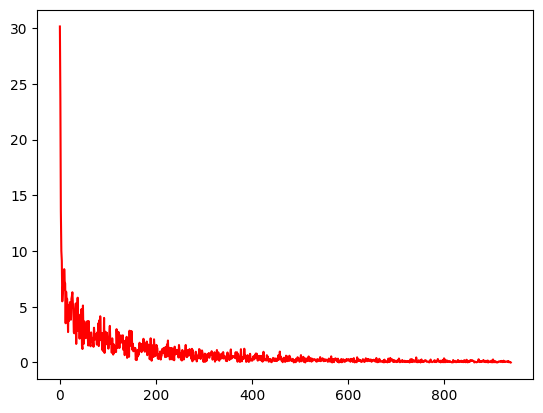

In [87]:
# 對訓練過程的損失繪圖
import matplotlib.pyplot as plt

cpu_loss_list = [loss.cpu().item() for loss in loss_list]
plt.plot(cpu_loss_list, 'r')

##步驟4：評分(Score Model)

In [88]:
# 建立 DataLoader
test_loader = DataLoader(test_ds, batch_size=600)

# 設置模型為評估模式
model.set_train_state(False)

test_loss = 0
correct = 0

# 不需要計算梯度
for data, target in test_loader:
    data, target = data.to(device), target.to(device)

    # 前向傳播
    outputs = model.forward(data)

    # 計算損失（假設均方誤差）
    loss, grad = cross_entropy_loss(outputs, target)

    # 累計損失
    test_loss += loss

    # 預測
    #pred = np.argmax(outputs, axis=0)
    pred = torch.argmax(outputs, dim=0)
    #print(pred)

    # 計算正確筆數
    #correct += np.sum(pred == target.cpu().numpy())
    correct += torch.sum(pred == target).item()

# 平均損失
test_loss /= len(test_loader.dataset)

# 顯示測試結果
data_count = len(test_loader.dataset)
accuracy = 100. * correct / data_count
print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' +
      f' ({accuracy:.0f}%)\n')


平均損失: 0.0003, 準確率: 9656/10000 (97%)

